# Constants and Libraries

## Only if needed

import os

# Login with tenant ID
os.system("az login --tenant 3ad0b905-34ab-4116-93d9-c1dcc2d35af6 --output none")

# Set the subscription programmatically
os.system("az account set --subscription eca2eddb-0f0c-4351-a634-52751499eeea")

In [1]:
import os
from IPython.display import Markdown, display
from dotenv import load_dotenv # requires python-dotenv
from PIL import Image # requires pip install pillow
from datetime import datetime
from common.agents_helper_functions_NEW import *
import importlib.metadata
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if not load_dotenv("./../config/credentials_my.env"):
    print("Environment variables not loaded, cell execution stopped")
else:
    print("Environment variables have been loaded ;-)")


project_endpoint = os.environ["PROJECT_ENDPOINT"]
api_version = os.environ["OPENAI_API_VERSION"] # at least "2025-03-01-preview"

print(f'Project Endpoint: <{project_endpoint}>')
print(f"azure-ai-projects library installed version: {importlib.metadata.version("azure-ai-projects")}")
print(f"azure-ai-agents library installed version: {importlib.metadata.version("azure-ai-agents")}")

Environment variables have been loaded ;-)
Project Endpoint: <https://mmai-swc-new01-prj-resource.services.ai.azure.com/api/projects/mmai-swc-new01-prj>
azure-ai-projects library installed version: 1.0.0b11
azure-ai-agents library installed version: 1.1.0b1


# Create AI Foundry Project Client

In [2]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    endpoint=project_endpoint,
    credential=DefaultAzureCredential(),
)

project_client

# [Create AI Foundry Agent Client](https://learn.microsoft.com/en-us/python/api/overview/azure/ai-agents-readme?view=azure-python-preview)
Please consider that `project_client.agens == agents_client`

In [3]:
from azure.ai.agents import AgentsClient

agents_client = AgentsClient(
    endpoint=project_endpoint,
    credential=DefaultAzureCredential(),
)

# Just for testing: List current AI Foundry Agents

In [4]:
# using project_client.agents...

agents = project_client.agents.list_agents()

[f"{a.id}: {a.name}" for a in agents]

[]

In [5]:
# using agents_client...

agents = agents_client.list_agents()

[f"{a.id}: {a.name}" for a in agents]

[]

# Create the [CodeInterpreterTool](https://learn.microsoft.com/en-us/azure/ai-services/agents/how-to/tools/code-interpreter-samples?pivots=python#code-interpreter-setup)

In [6]:
from azure.ai.agents.models import CodeInterpreterTool

code_interpreter = CodeInterpreterTool()
print(f"Code interpreter definitions: {code_interpreter.definitions}")
print(f"Code interpreter resources: {code_interpreter.resources}")

Code interpreter definitions: [{'type': 'code_interpreter'}]
Code interpreter resources: {}


# Create AI Foundry Agent with its CodeInterpreterTool for AI Agents

In [7]:
# using project_client.agents...
ai_agent = project_client.agents.create_agent(
    model=os.environ["MODEL_DEPLOYMENT_NAME"],
    name="my-agent",
    instructions="You are helpful agent",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)

print(f"Created agent, agent ID: {ai_agent.id},\nagent items: {ai_agent.items}")

Created agent, agent ID: asst_2NVnA01V2Y7QmUSW0tMTburf,
agent items: <bound method _MyMutableMapping.items of {'id': 'asst_2NVnA01V2Y7QmUSW0tMTburf', 'object': 'assistant', 'created_at': 1748478123, 'name': 'my-agent', 'description': None, 'model': 'gpt-4o', 'instructions': 'You are helpful agent', 'tools': [{'type': 'code_interpreter'}], 'top_p': 1.0, 'temperature': 1.0, 'tool_resources': {'code_interpreter': {'file_ids': []}}, 'metadata': {}, 'response_format': 'auto'}>


# Just for testing: create a new agent and delete it

In [8]:
# Create a second agent
ai_agent_02 = agents_client.create_agent( # using agents_client
    model=os.environ["MODEL_DEPLOYMENT_NAME"],
    name="my-agent02 to be deleted",
    instructions="You are helpful agent",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)

# List all agents
print(f"All agents, including the useless one:")
display([f"{a.id}: {a.name}" for a in project_client.agents.list_agents()]) # using project_client.agents

agents_client.delete_agent(ai_agent_02.id) # using agents_client

# List all agents
print(f"\nAll agents, after deleting the useless one:")
display([f"{a.id}: {a.name}" for a in project_client.agents.list_agents()])

All agents, including the useless one:


['asst_fyZmXpboEFnp1ab0Gg0WDvzO: my-agent02 to be deleted',
 'asst_2NVnA01V2Y7QmUSW0tMTburf: my-agent']


All agents, after deleting the useless one:


['asst_2NVnA01V2Y7QmUSW0tMTburf: my-agent']

# Create the thread and attach a new message to it

In [9]:
from azure.ai.agents.models import MessageRole

# Create a thread
thread = project_client.agents.threads.create()
print(f"Created thread: {thread}\n")

message = project_client.agents.messages.create(
    thread_id=thread.id,
    role=MessageRole.USER,
    content="""
    Could you please create a bar chart for the operating profit using 
    the following data and provide the file to me? 
    Company A: $1.2 million, Company B: $2.5 million, Company C: $3.0 million, 
    Company D: $1.8 million
    """,
)

Created thread: {'id': 'thread_Fk2YbBBgTLvH8OXgDSj0m3Hn', 'object': 'thread', 'created_at': 1748478126, 'metadata': {}, 'tool_resources': {}}



# Run the agent syncrhonously

In [10]:
%%time

# Run the agent
run = project_client.agents.runs.create_and_process\
    (thread_id=thread.id, agent_id=ai_agent.id)

print(f"Run status: {run.status}.\n\nRun details: {run}")

Run status: RunStatus.COMPLETED.

Run details: {'id': 'run_9hNY4RqOktGvN0eiVFms3grM', 'object': 'thread.run', 'created_at': 1748478128, 'assistant_id': 'asst_2NVnA01V2Y7QmUSW0tMTburf', 'thread_id': 'thread_Fk2YbBBgTLvH8OXgDSj0m3Hn', 'status': 'completed', 'started_at': 1748478128, 'expires_at': None, 'cancelled_at': None, 'failed_at': None, 'completed_at': 1748478133, 'required_action': None, 'last_error': None, 'model': 'gpt-4o', 'instructions': 'You are helpful agent', 'tools': [{'type': 'code_interpreter'}], 'tool_resources': {}, 'metadata': {}, 'temperature': 1.0, 'top_p': 1.0, 'max_completion_tokens': None, 'max_prompt_tokens': None, 'truncation_strategy': {'type': 'auto', 'last_messages': None}, 'incomplete_details': None, 'usage': {'prompt_tokens': 618, 'completion_tokens': 213, 'total_tokens': 831, 'prompt_token_details': {'cached_tokens': 0}}, 'response_format': 'auto', 'tool_choice': 'auto', 'parallel_tool_calls': True}
CPU times: user 21 ms, sys: 1.14 ms, total: 22.1 ms
Wall

# Fetch messages from the thread after the agent run execution

In [11]:
from azure.ai.agents.models import MessageTextContent, MessageImageFileContent

annotations = []
image_files = []

if run.status == 'completed':
    messages = project_client.agents.messages.list(thread_id=thread.id)
    messages_list = list(project_client.agents.messages.list(thread_id=thread.id))  # Convert iterator to a list
    messages_nr = len(messages_list)
    print(f"Here are the {messages_nr} messages:\n")
    
    for i, message in enumerate(reversed(messages_list), 1):
        j = 0
        print(f"\n===== MESSAGE {i} =====")
        for c in message.content:
            j +=1
            if (type(c) is MessageTextContent):
                print(f"\nMessage {i} / CONTENT {j} (MessageTextContent) --> Text: {c.text.value}")
                for a in c.text.annotations:
                    print(f">>> Annotation in MessageTextContent {j} of message {i}: {a.text}\n")
                    annotations.append(a)
            elif (type(c) is MessageImageFileContent):
                print(f"\nMessage {i} / CONTENT {j} (MessageImageFileContent) --> image_file id: {c.image_file.file_id}")
                image_files.append(c.image_file.file_id)

else:
    print(f"Sorry, I can't proceed because the run status is {run.status}")

Here are the 2 messages:


===== MESSAGE 1 =====

Message 1 / CONTENT 1 (MessageTextContent) --> Text: 
    Could you please create a bar chart for the operating profit using 
    the following data and provide the file to me? 
    Company A: $1.2 million, Company B: $2.5 million, Company C: $3.0 million, 
    Company D: $1.8 million
    

===== MESSAGE 2 =====

Message 2 / CONTENT 1 (MessageTextContent) --> Text: The bar chart for the operating profit has been created and saved. You can download it using the link below:

[Download the bar chart](sandbox:/mnt/data/operating_profit_chart.png)
>>> Annotation in MessageTextContent 1 of message 2: sandbox:/mnt/data/operating_profit_chart.png



# Retrieve and download eventual annotations

Nr. of file path annotations: 1

1 - File annotation paths: sandbox:/mnt/data/operating_profit_chart.png

>>> file <assistant-M5ThbVf245vAYcDuAMavZT> saved as <operating_profit_chart.png>
File annotation 1 saved as file to: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dsvm-mem-optimized04/code/Users/mauro.minella/git_repos/aaas/operating_profit_chart.png


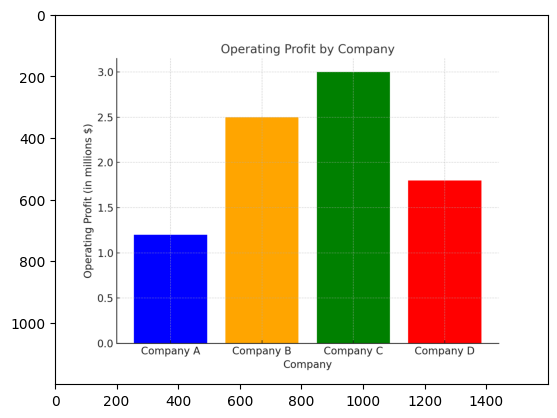

In [12]:
print (f"Nr. of file path annotations: {len(annotations)}\n")

i=0
for a in annotations:
    i += 1
    print(f"{i} - File annotation paths: {a.text}")
    file_name = a.text.split('/')[-1]
    file_id = a.file_path.file_id

    #agents_client.files.save(file_id=file_id, file_name=file_name)
    project_client.agents.files.save(file_id=file_id, file_name=file_name)
    print(f"\n>>> file <{file_id}> saved as <{file_name}>")
    
    # project_client.agents.save_file(file_id=file_path_annotation.file_path.file_id, file_name=file_name)
    print(f"File annotation {i} saved as file to: {os.getcwd()}/{file_name}")
    image = mpimg.imread(f"{os.getcwd()}/{file_name}") # read the image
    plt.imshow(image)
    plt.show()

# Retrieve and download eventual images

In [13]:
messages_list

[{'id': 'msg_FZAfJNzrBvunU5KR6EDLPHDo', 'object': 'thread.message', 'created_at': 1748478132, 'assistant_id': 'asst_2NVnA01V2Y7QmUSW0tMTburf', 'thread_id': 'thread_Fk2YbBBgTLvH8OXgDSj0m3Hn', 'run_id': 'run_9hNY4RqOktGvN0eiVFms3grM', 'role': 'assistant', 'content': [{'type': 'text', 'text': {'value': 'The bar chart for the operating profit has been created and saved. You can download it using the link below:\n\n[Download the bar chart](sandbox:/mnt/data/operating_profit_chart.png)', 'annotations': [{'type': 'file_path', 'text': 'sandbox:/mnt/data/operating_profit_chart.png', 'start_index': 135, 'end_index': 179, 'file_path': {'file_id': 'assistant-M5ThbVf245vAYcDuAMavZT'}}]}}], 'attachments': [{'file_id': 'assistant-M5ThbVf245vAYcDuAMavZT', 'tools': [{'type': 'code_interpreter'}]}], 'metadata': {}},
 {'id': 'msg_CVzRSLtWuoTSS8CqQwEr7sR7', 'object': 'thread.message', 'created_at': 1748478126, 'assistant_id': None, 'thread_id': 'thread_Fk2YbBBgTLvH8OXgDSj0m3Hn', 'run_id': None, 'role': 'u

In [14]:
print (f"Nr. of image contents: {len(image_files)}\n")

i=0
# Generate an image file for the bar chart
for image_file in image_files:
    i += 1
    print(f"{i} - Image file id: {image_file}")
    file_name = f"{image_file}.png"
    project_client.agents.files.save(file_id=image_file, file_name=file_name)
    print(f"Image content {i} file to: {os.getcwd()}/{file_name}")
    image = mpimg.imread(f"{os.getcwd()}/{file_name}") # read the image
    plt.imshow(image)
    plt.show()

Nr. of image contents: 0



# Collect **all** resources for this project

In [15]:
def list_all_vectorstores (project_client:AIProjectClient, limit:int = 100):
    all_vectorstores = list(agents_client.vector_stores.list())[:limit] # Convert iterator to a list
    summary = f'{len(all_vectorstores)} vector stores'    
    return {"summary": summary, "content": all_vectorstores}

all_vectorstores = list_all_vectorstores(project_client=project_client)
print(all_vectorstores["summary"])

0 vector stores


In [16]:
all_agents = list_all_agents(project_client=project_client)
print(all_agents["summary"])

all_threads = list_all_threads(project_client)
print(all_threads["summary"])

all_files = list_all_files(project_client)
print(all_files["summary"])

all_runs = list_all_runs(project_client)
print(all_runs["summary"])

# all_runsteps=list_all_runsteps(project_client)
# print(all_runsteps["summary"])

# all_messages = list_all_messages(project_client)
# print(all_messages["summary"])

all_vectorstores = list_all_vectorstores(project_client=project_client)
print(all_vectorstores["summary"])

1 agents
1 threads
1 files
1 runs in 1 threads
0 vector stores


# Teardown for **all** resources

In [17]:
# delete all vector stores

i=0
for vector_store in all_vectorstores["content"]:
    i += 1
    project_client.agents.vector_stores.delete(vector_store_id=vector_store.id)
    print(f"{i} - Vector store <{vector_store.id}> has been deleted")

all_vectorstores = list_all_vectorstores(project_client=project_client)

print(f"Vector stores deleted: {i}\n")

Vector stores deleted: 0



In [18]:
# delete all files

i=0
for file in all_files['content']:
    i += 1
    project_client.agents.files.delete(file_id=file.id)
    print(f"{i} - File <{file.filename}> ({file.id}) has been deleted")

all_files = list_all_files(project_client)

print(f"Files deleted: {i}\n")

1 - File </mnt/data/operating_profit_chart.png> (assistant-M5ThbVf245vAYcDuAMavZT) has been deleted
Files deleted: 1



In [19]:
# delete all threads

i=0
for thread in all_threads["content"]:
    i += 1
    project_client.agents.threads.delete(thread_id=thread.id)
    print(f"{i} - Thread <{thread.id}> has been deleted")

all_threads = list_all_threads(project_client)

print(f"Threads deleted: {i}\n")

1 - Thread <thread_Fk2YbBBgTLvH8OXgDSj0m3Hn> has been deleted
Threads deleted: 1



In [20]:
# delete all agents

i=0
for agent in all_agents["content"]:
    i += 1
    project_client.agents.delete_agent(agent_id=agent.id)
    print(f"{i} - Agent <{agent.id}> has been deleted")

all_agents = list_all_agents(project_client=project_client)

print(f"Agents deleted: {i}\n")

1 - Agent <asst_2NVnA01V2Y7QmUSW0tMTburf> has been deleted
Agents deleted: 1



# HIC SUNT LEONES